In [1]:
%matplotlib notebook
import orbipy as op
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from copy import copy

In [64]:
from scipy.interpolate import interp1d

In [2]:
model = op.crtbp3_model()
precise_model = op.crtbp3_model()
precise_model.integrator.set_params(max_step=np.pi/180)
plotter = op.plotter.from_model(model, length_units='nd', velocity_units='nd/nd')
scaler = plotter.scaler

In [3]:
EL1_dist = 1.-model.mu - model.L1
left = op.eventX(model.L1-EL1_dist)
right = op.eventX(1.-model.mu)

In [10]:
corr = op.border_correction(model, op.y_direction(), [left], [right])
sk = op.simple_station_keeping(precise_model, corr, corr, rev=np.pi)

In [5]:
def interactive_map(data, buffer):
    def onclick(event):
        if event.button == 3:
            ix, iy = event.xdata, event.ydata
            buffer.append([ix, iy])
            ax.plot(ix, iy, 'or')
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(data['x0'], data['z0'], 'ob')
    ax.plot(s0[0],s0[2],'xr')
    ax.axis('equal')
    cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [6]:
with open('amp.pkl', 'rb') as fp:
    applicability = pickle.load(fp)

<IPython.core.display.Javascript object>


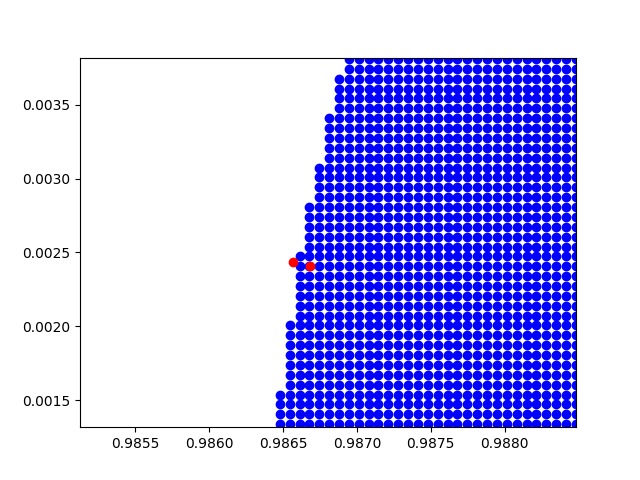

In [77]:
buffer = []
interactive_map(applicability, buffer)

In [150]:
x0 = buffer[-1][0]
z0 = buffer[-1][1]

x0 = 0.9866819361250985
z0 = 0.0024088035063909354

In [55]:
s0 = model.get_zero_state()
s0[0] = x0
s0[2] = z0

In [56]:
df = sk.prop(0.0, s0, N=30)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


<IPython.core.display.Javascript object>


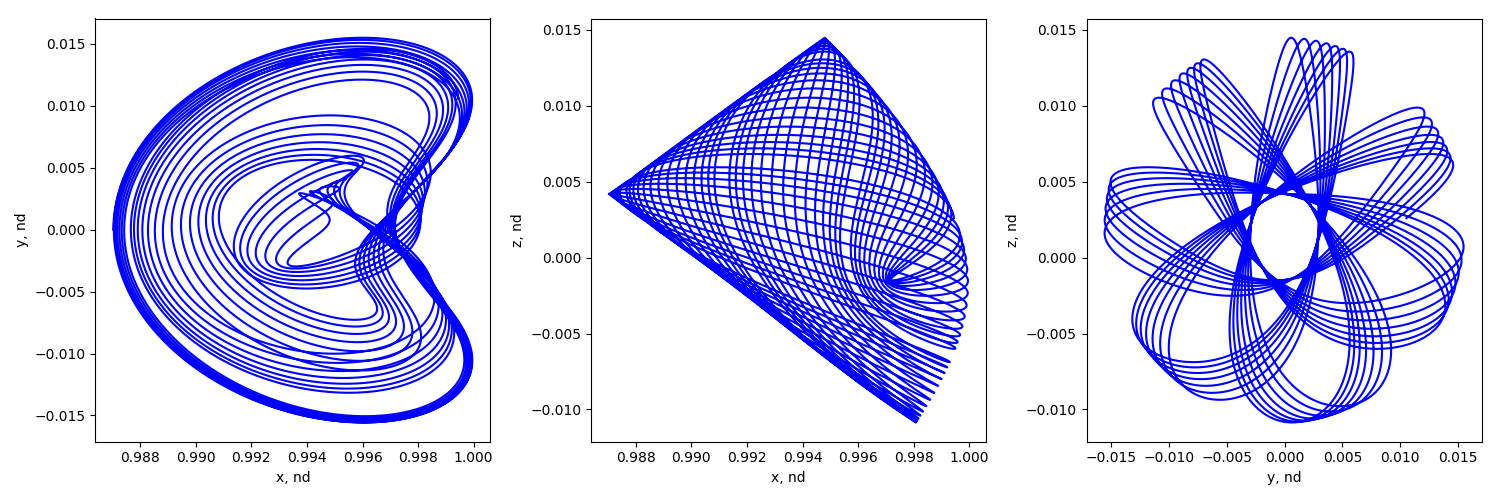

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f58be8b3f60>,
      dtype=object)

In [57]:
plotter.plot_proj(df)

In [81]:
def prepare_step(x0, z0, dx):
    EL1_dist = 1.-model.mu - model.L1
    left = op.eventX(model.L1-EL1_dist)
    right = op.eventX(1.-model.mu)

    corr = op.border_correction(model, op.y_direction(), [left], [right])
    sk = op.simple_station_keeping(model, corr, corr)
    
    xmax_vals = []
    x0_vals = []
    vy0_vals = []
    
    for x in [x0+dx, x0+2*dx, x0+3*dx, x0+4*dx]:
        x0_vals.append(x)
        s0 = model.get_zero_state()
        s0[0] = x
        s0[2] = z0

        df = sk.prop(0.0, s0, N=30)
        xmax_vals.append(df['x'].max())
        vy0_vals.append(df.iloc[0].values[5])
        
    
    return x0_vals, xmax_vals, vy0_vals

In [144]:
def run_calculations(x0, z0, dx, steps, data=None, max_attempts = 20):
    if data == None:
        x0_vals, xmax_vals, vy0_vals = prepare_step(x0, z0, dx)
    else:
        x0_vals, xmax_vals, vy0_vals = data
    
    i = 0
    orbs = []
    
    result = {'orbs': orbs, 'x0': x0_vals, 'vy0': vy0_vals, 'xmax': xmax_vals}
    
    while i < steps:
        print('STEP: {}'.format(i))
        xmax_int = interp1d(x0_vals, xmax_vals, kind='cubic', fill_value='extrapolate')
        vy0_int = interp1d(x0_vals, vy0_vals, kind='cubic', fill_value='extrapolate')
        
        x = x0_vals[-1] + dx
        xmax = xmax_int([x])[0]
        vy = vy0_int([x])[0]
        
        s0 = model.get_zero_state()
        s0[0] = x
        s0[2] = z0
        s0[4] = vy
        
        ileft = op.eventX(model.L1-EL1_dist)
        iright = op.eventX(xmax)
        
        corr = op.border_correction(model, op.y_direction(), [ileft], [iright], dv0=1e-8)
        sk = op.simple_station_keeping(model, corr, corr)
        
        for attempt in range(max_attempts):
            try:
                print('ATTEMPT: {}'.format(attempt))
                iright.value += attempt*scaler(100, 'km-nd')
                df = sk.prop(0.0, s0, N=30)
            except Exception as e:
#                 print(e)
                print(iright.value)
            else:
                break
        else:
            result['debug'] = [x, vy, xmax]
            result['arr'] = sk.arr
            return result
#         import pdb; pdb.set_trace()
        orbs.append(df)
        x0_vals.append(df.iloc[0].values[1])
        vy0_vals.append(df.iloc[0].values[5])
        xmax_vals.append(df['x'].max())
        i = i+1
    return result

In [127]:
dx = -1*scaler(1000, 'km-nd')

In [151]:
prep_data = prepare_step(x0, z0, dx)

Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 


In [152]:
res = run_calculations(x0, z0, dx, 100, prep_data, 50)

STEP: 0
ATTEMPT: 0
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 0.9998337015568405
ATTEMPT: 1
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
STEP: 1
ATTEMPT: 0
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 0.9998494914493189
ATTEMPT: 1
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 0.9998501598985168
ATTEMPT: 2
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 0.9998514967969125
ATTEMPT: 3
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
STEP: 2
ATTEMPT: 0
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
STEP: 3
ATTEMPT: 0
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
STEP: 4
ATTEMPT: 0
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 0.9999014612837678
ATTEMPT: 1
Simple station-keeping: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 0.999902

<IPython.core.display.Javascript object>


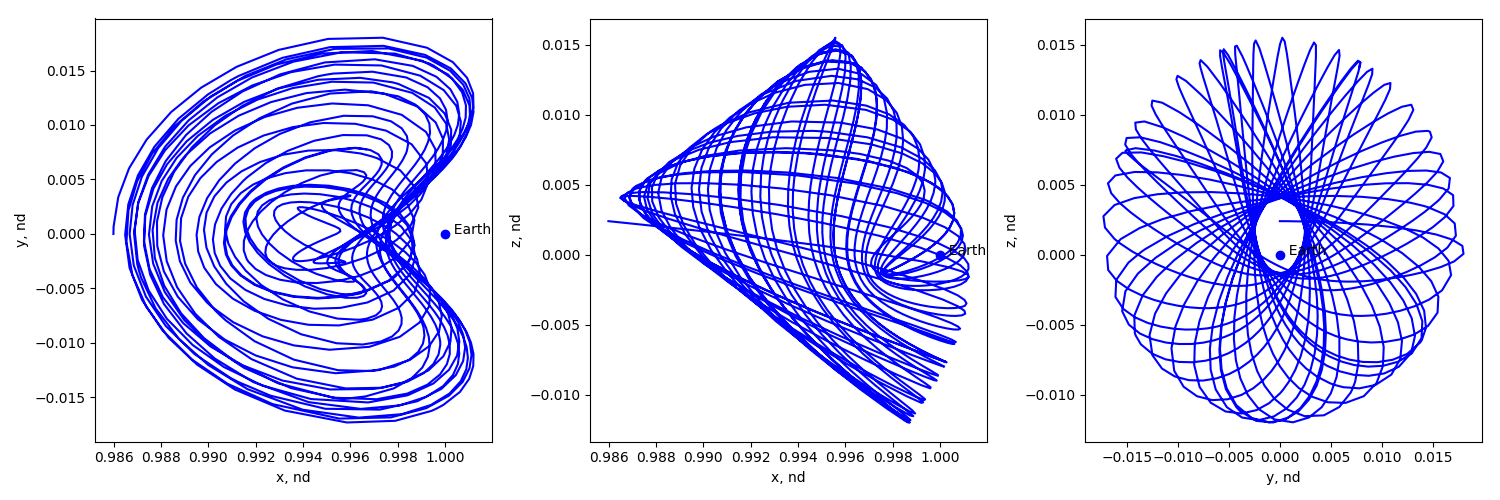

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f58bab86c18>,
      dtype=object)

In [154]:
ax = plotter.plot_proj(res['orbs'][-1])
plotter.plot_proj(ax=ax, plottables=[plotter.m], marker='o')

In [156]:
with open('res.bin', 'wb') as fp:
    pickle.dump(res, fp)

<IPython.core.display.Javascript object>


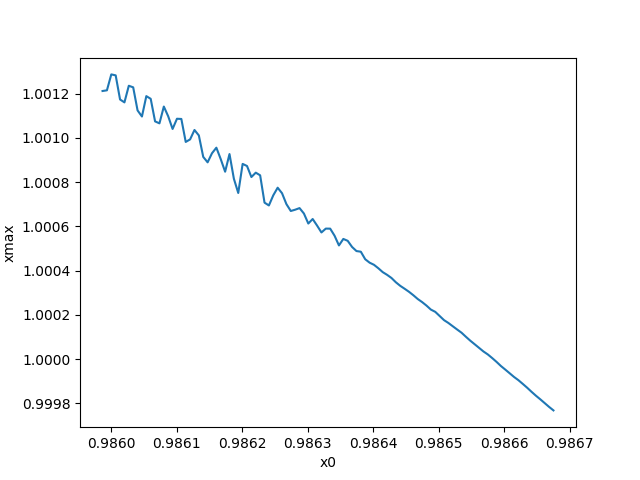

Text(0, 0.5, 'xmax')

In [159]:
plt.plot(res['x0'], res['xmax'])
plt.xlabel('x0')
plt.ylabel('xmax')

<IPython.core.display.Javascript object>


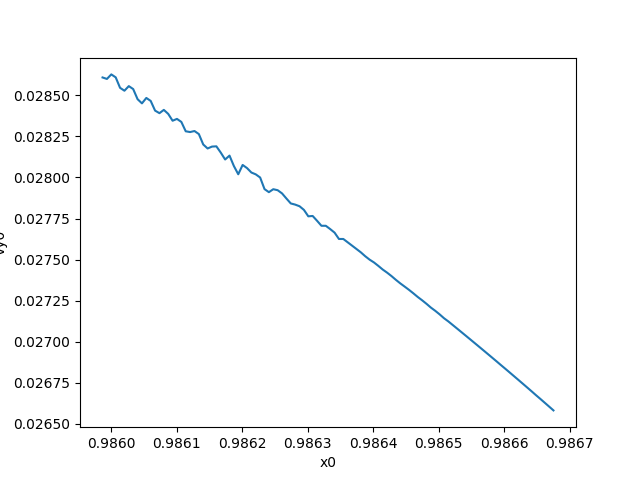

Text(0, 0.5, 'vy0')

In [162]:
plt.plot(res['x0'], res['vy0'])
plt.xlabel('x0')
plt.ylabel('vy0')

<IPython.core.display.Javascript object>


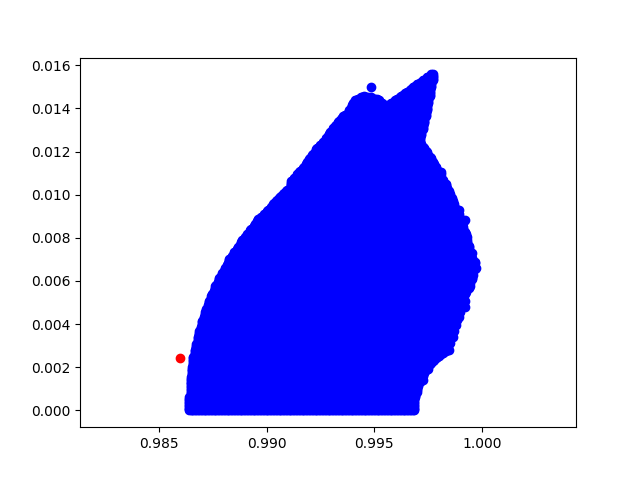

(0.9853004212203008,
 1.0003996314788053,
 -0.0007787433155080214,
 0.01635360962566845)

In [166]:
plt.plot(applicability['x0'], applicability['z0'], 'ob')
plt.plot(res['x0'][-1], z0, 'or')
plt.axis('equal')